In [6]:
# 1. IMPORTS & CONFIGURATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# UPDATE: Using the v2 dataset
BASE_DIR = r"C:\Users\ayber\OneDrive\Masaüstü\ML"
DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready_v2.csv.gz") 
MODEL_DIR = os.path.join(BASE_DIR, "Models")
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print(f"Data shape: {df.shape}")
print(df.head())

Loading data from: C:\Users\ayber\OneDrive\Masaüstü\ML\Data/processed/irb2400_ready_v2.csv
Data shape: (300000, 27)
   target_x  target_y  target_z   sin_yaw  cos_yaw  sin_pitch  cos_pitch  \
0 -0.080915  -0.12175  1.896487 -0.639694  0.76863   0.797355    0.60351   
1 -0.080915  -0.12175  1.896487 -0.639694  0.76863   0.797355    0.60351   
2 -0.080915  -0.12175  1.896487 -0.639694  0.76863   0.797355    0.60351   
3 -0.080915  -0.12175  1.896487 -0.639694  0.76863   0.797355    0.60351   
4 -0.080915  -0.12175  1.896487 -0.639694  0.76863   0.797355    0.60351   

   sin_roll  cos_roll       q1_in  ...  delta_q3  delta_q4  delta_q5  \
0 -0.991601  0.129333 -128.382653  ... -2.509555  0.847978  5.185268   
1 -0.991601  0.129333 -127.385707  ...  0.842248 -2.985110  2.606958   
2 -0.991601  0.129333 -129.299386  ...  1.678766  1.856383  5.139431   
3 -0.991601  0.129333 -123.512512  ...  3.328885 -4.858682 -3.323155   
4 -0.991601  0.129333 -133.310090  ... -3.489313  0.148969 -0.85370

In [8]:
# 2. DEFINE NEW FEATURES
# We replaced raw angles with Sin/Cos pairs
feature_cols = [
    'target_x', 'target_y', 'target_z', 
    'sin_yaw', 'cos_yaw', 
    'sin_pitch', 'cos_pitch', 
    'sin_roll', 'cos_roll',
    'q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in'
]

target_cols = ['delta_q1', 'delta_q2', 'delta_q3', 'delta_q4', 'delta_q5', 'delta_q6']

print(f"Input Features: {len(feature_cols)} (Added Sin/Cos)")

Input Features: 15 (Added Sin/Cos)


In [9]:
# 3. PREPROCESSING
X = df[feature_cols].values
y = df[target_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [10]:
# WIDER MODEL TRAINING
# NOTE on MAE: MLPRegressor does not support 'absolute_error' loss directly.
# However, making the network wider (more neurons) helps it approximate the function better,
# which reduces MAE indirectly.

print("Initializing Wider MLP Regressor...")
model = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # Significantly Wider & Deeper
    activation='relu',                   # ReLU activation for non-linearity
    solver='adam',                       # Adam optimizer
    max_iter=500,                        # More iterations for convergence   
    batch_size=1024,                     # Larger batch size for stability
    learning_rate_init=0.001,            # Slightly higher LR for faster convergence
    tol=0.001,                           # Loose tolerance for faster training
    early_stopping=True,                 # Enable early stopping
    validation_fraction=0.1,             # 10% for validation
    n_iter_no_change=20,                 # Lower patience for early stopping
    random_state=2,                      # For reproducibility
    verbose=True                         # Show training progress
)

print("Starting training...")
model.fit(X_train_scaled, y_train_scaled)
print("Training complete.")

Initializing Wider MLP Regressor...
Starting training...
Iteration 1, loss = 0.49595660
Validation score: 0.046503
Iteration 2, loss = 0.43323422
Validation score: 0.189327
Iteration 3, loss = 0.39269988
Validation score: 0.237761
Iteration 4, loss = 0.36816476
Validation score: 0.281435
Iteration 5, loss = 0.34844948
Validation score: 0.318316
Iteration 6, loss = 0.33223293
Validation score: 0.340754
Iteration 7, loss = 0.31998629
Validation score: 0.367788
Iteration 8, loss = 0.31080125
Validation score: 0.384048
Iteration 9, loss = 0.30477595
Validation score: 0.395539
Iteration 10, loss = 0.29853829
Validation score: 0.402057
Iteration 11, loss = 0.29545542
Validation score: 0.411325
Iteration 12, loss = 0.29212671
Validation score: 0.419316
Iteration 13, loss = 0.28891079
Validation score: 0.420790
Iteration 14, loss = 0.28686637
Validation score: 0.428777
Iteration 15, loss = 0.28449828
Validation score: 0.429570
Iteration 16, loss = 0.28309209
Validation score: 0.431132
Iteratio

In [12]:
# 5. EVALUATION
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*30)
print("       V2 MODEL RESULTS       ")
print("="*30)
print(f"Mean Absolute Error: {mae:.4f} degrees")
print(f"RMSE:                {rmse:.4f} degrees")
print("-" * 30)

# 6. SAVE UPDATED MODELS
joblib.dump(model, os.path.join(MODEL_DIR, "mlp_baseline_v2.pkl"))
joblib.dump(scaler_x, os.path.join(MODEL_DIR, "scaler_x_v2.pkl"))
joblib.dump(scaler_y, os.path.join(MODEL_DIR, "scaler_y_v2.pkl"))
print("Saved v2 models.")


       V2 MODEL RESULTS       
Mean Absolute Error: 1.4894 degrees
RMSE:                2.1819 degrees
------------------------------
Saved v2 models.


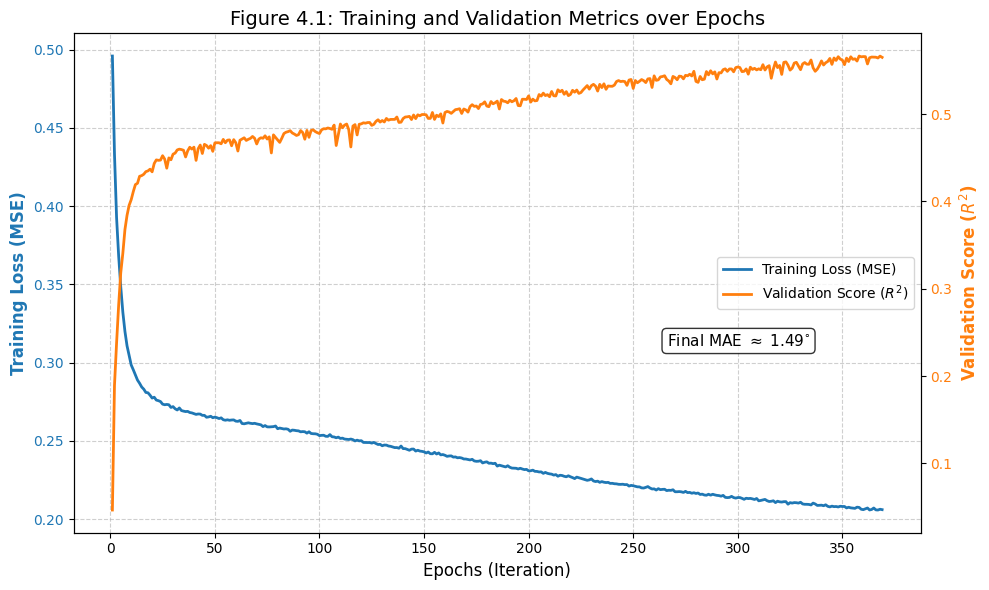

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# The full log data provided
data_text = """
Initializing Wider MLP Regressor...
Starting training...
Iteration 1, loss = 0.49595660
Validation score: 0.046503
Iteration 2, loss = 0.43323422
Validation score: 0.189327
Iteration 3, loss = 0.39269988
Validation score: 0.237761
Iteration 4, loss = 0.36816476
Validation score: 0.281435
Iteration 5, loss = 0.34844948
Validation score: 0.318316
Iteration 6, loss = 0.33223293
Validation score: 0.340754
Iteration 7, loss = 0.31998629
Validation score: 0.367788
Iteration 8, loss = 0.31080125
Validation score: 0.384048
Iteration 9, loss = 0.30477595
Validation score: 0.395539
Iteration 10, loss = 0.29853829
Validation score: 0.402057
Iteration 11, loss = 0.29545542
Validation score: 0.411325
Iteration 12, loss = 0.29212671
Validation score: 0.419316
Iteration 13, loss = 0.28891079
Validation score: 0.420790
Iteration 14, loss = 0.28686637
Validation score: 0.428777
Iteration 15, loss = 0.28449828
Validation score: 0.429570
Iteration 16, loss = 0.28309209
Validation score: 0.431132
Iteration 17, loss = 0.28100064
Validation score: 0.434123
Iteration 18, loss = 0.28079760
Validation score: 0.434964
Iteration 19, loss = 0.27923783
Validation score: 0.436953
Iteration 20, loss = 0.27740837
Validation score: 0.433906
Iteration 21, loss = 0.27795015
Validation score: 0.443484
Iteration 22, loss = 0.27611511
Validation score: 0.447578
Iteration 23, loss = 0.27574444
Validation score: 0.447084
Iteration 24, loss = 0.27517677
Validation score: 0.447351
Iteration 25, loss = 0.27352590
Validation score: 0.452378
Iteration 26, loss = 0.27314531
Validation score: 0.448492
Iteration 27, loss = 0.27333601
Validation score: 0.438081
Iteration 28, loss = 0.27314650
Validation score: 0.449879
Iteration 29, loss = 0.27141745
Validation score: 0.447747
Iteration 30, loss = 0.27194265
Validation score: 0.454125
Iteration 31, loss = 0.27056575
Validation score: 0.455382
Iteration 32, loss = 0.26979315
Validation score: 0.458987
Iteration 33, loss = 0.27108817
Validation score: 0.459869
Iteration 34, loss = 0.26943321
Validation score: 0.459414
Iteration 35, loss = 0.26906160
Validation score: 0.458618
Iteration 36, loss = 0.26877600
Validation score: 0.450971
Iteration 37, loss = 0.26889884
Validation score: 0.457962
Iteration 38, loss = 0.26817807
Validation score: 0.462073
Iteration 39, loss = 0.26792672
Validation score: 0.459942
Iteration 40, loss = 0.26745313
Validation score: 0.462189
Iteration 41, loss = 0.26697741
Validation score: 0.447026
Iteration 42, loss = 0.26724226
Validation score: 0.460360
Iteration 43, loss = 0.26717307
Validation score: 0.464577
Iteration 44, loss = 0.26635264
Validation score: 0.454911
Iteration 45, loss = 0.26636832
Validation score: 0.465395
Iteration 46, loss = 0.26515357
Validation score: 0.464058
Iteration 47, loss = 0.26536599
Validation score: 0.460991
Iteration 48, loss = 0.26578114
Validation score: 0.463921
Iteration 49, loss = 0.26485216
Validation score: 0.457386
Iteration 50, loss = 0.26523570
Validation score: 0.467039
Iteration 51, loss = 0.26485669
Validation score: 0.467222
Iteration 52, loss = 0.26430751
Validation score: 0.467179
Iteration 53, loss = 0.26476910
Validation score: 0.466011
Iteration 54, loss = 0.26356400
Validation score: 0.471053
Iteration 55, loss = 0.26324550
Validation score: 0.467239
Iteration 56, loss = 0.26350951
Validation score: 0.470162
Iteration 57, loss = 0.26321535
Validation score: 0.470485
Iteration 58, loss = 0.26338983
Validation score: 0.463763
Iteration 59, loss = 0.26345647
Validation score: 0.470774
Iteration 60, loss = 0.26267022
Validation score: 0.467252
Iteration 61, loss = 0.26253138
Validation score: 0.457737
Iteration 62, loss = 0.26309521
Validation score: 0.470104
Iteration 63, loss = 0.26115386
Validation score: 0.471482
Iteration 64, loss = 0.26096681
Validation score: 0.472896
Iteration 65, loss = 0.26128381
Validation score: 0.469856
Iteration 66, loss = 0.26159254
Validation score: 0.471190
Iteration 67, loss = 0.26129310
Validation score: 0.472241
Iteration 68, loss = 0.26107998
Validation score: 0.474436
Iteration 69, loss = 0.26128193
Validation score: 0.472315
Iteration 70, loss = 0.26090259
Validation score: 0.465816
Iteration 71, loss = 0.26062151
Validation score: 0.471380
Iteration 72, loss = 0.26031522
Validation score: 0.472932
Iteration 73, loss = 0.25918558
Validation score: 0.472345
Iteration 74, loss = 0.25984151
Validation score: 0.475171
Iteration 75, loss = 0.25901600
Validation score: 0.471487
Iteration 76, loss = 0.25895683
Validation score: 0.473992
Iteration 77, loss = 0.25902670
Validation score: 0.455541
Iteration 78, loss = 0.25915909
Validation score: 0.476260
Iteration 79, loss = 0.25955010
Validation score: 0.473293
Iteration 80, loss = 0.25782321
Validation score: 0.470548
Iteration 81, loss = 0.25824185
Validation score: 0.467621
Iteration 82, loss = 0.25791080
Validation score: 0.472430
Iteration 83, loss = 0.25764736
Validation score: 0.477754
Iteration 84, loss = 0.25776377
Validation score: 0.479274
Iteration 85, loss = 0.25746394
Validation score: 0.479968
Iteration 86, loss = 0.25618896
Validation score: 0.481027
Iteration 87, loss = 0.25696204
Validation score: 0.478414
Iteration 88, loss = 0.25682238
Validation score: 0.477137
Iteration 89, loss = 0.25657009
Validation score: 0.475579
Iteration 90, loss = 0.25644642
Validation score: 0.476488
Iteration 91, loss = 0.25584355
Validation score: 0.481188
Iteration 92, loss = 0.25598831
Validation score: 0.478881
Iteration 93, loss = 0.25587104
Validation score: 0.471281
Iteration 94, loss = 0.25500395
Validation score: 0.481348
Iteration 95, loss = 0.25587648
Validation score: 0.473444
Iteration 96, loss = 0.25477434
Validation score: 0.481283
Iteration 97, loss = 0.25461435
Validation score: 0.481982
Iteration 98, loss = 0.25457081
Validation score: 0.480000
Iteration 99, loss = 0.25428152
Validation score: 0.478720
Iteration 100, loss = 0.25339898
Validation score: 0.477747
Iteration 101, loss = 0.25358144
Validation score: 0.481972
Iteration 102, loss = 0.25366026
Validation score: 0.483251
Iteration 103, loss = 0.25299328
Validation score: 0.483157
Iteration 104, loss = 0.25293348
Validation score: 0.484139
Iteration 105, loss = 0.25406096
Validation score: 0.483533
Iteration 106, loss = 0.25269124
Validation score: 0.482612
Iteration 107, loss = 0.25255626
Validation score: 0.487410
Iteration 108, loss = 0.25203805
Validation score: 0.464049
Iteration 109, loss = 0.25245616
Validation score: 0.476320
Iteration 110, loss = 0.25160813
Validation score: 0.488708
Iteration 111, loss = 0.25180133
Validation score: 0.484380
Iteration 112, loss = 0.25121504
Validation score: 0.487411
Iteration 113, loss = 0.25106004
Validation score: 0.488630
Iteration 114, loss = 0.25093069
Validation score: 0.482229
Iteration 115, loss = 0.25121290
Validation score: 0.462422
Iteration 116, loss = 0.25081752
Validation score: 0.486354
Iteration 117, loss = 0.25002036
Validation score: 0.488002
Iteration 118, loss = 0.25051389
Validation score: 0.476168
Iteration 119, loss = 0.25005981
Validation score: 0.488376
Iteration 120, loss = 0.25018895
Validation score: 0.488846
Iteration 121, loss = 0.24906276
Validation score: 0.490064
Iteration 122, loss = 0.24902263
Validation score: 0.489647
Iteration 123, loss = 0.24899534
Validation score: 0.490348
Iteration 124, loss = 0.24901707
Validation score: 0.490423
Iteration 125, loss = 0.24861007
Validation score: 0.487130
Iteration 126, loss = 0.24908012
Validation score: 0.488315
Iteration 127, loss = 0.24836127
Validation score: 0.491684
Iteration 128, loss = 0.24773589
Validation score: 0.493565
Iteration 129, loss = 0.24784095
Validation score: 0.490866
Iteration 130, loss = 0.24693276
Validation score: 0.492709
Iteration 131, loss = 0.24739161
Validation score: 0.491030
Iteration 132, loss = 0.24734738
Validation score: 0.495035
Iteration 133, loss = 0.24677224
Validation score: 0.493075
Iteration 134, loss = 0.24657158
Validation score: 0.493946
Iteration 135, loss = 0.24618264
Validation score: 0.494023
Iteration 136, loss = 0.24575228
Validation score: 0.493974
Iteration 137, loss = 0.24578272
Validation score: 0.496692
Iteration 138, loss = 0.24536261
Validation score: 0.490474
Iteration 139, loss = 0.24675143
Validation score: 0.490805
Iteration 140, loss = 0.24510625
Validation score: 0.494955
Iteration 141, loss = 0.24509404
Validation score: 0.496682
Iteration 142, loss = 0.24456389
Validation score: 0.496924
Iteration 143, loss = 0.24406422
Validation score: 0.497421
Iteration 144, loss = 0.24478680
Validation score: 0.493797
Iteration 145, loss = 0.24484222
Validation score: 0.499030
Iteration 146, loss = 0.24354905
Validation score: 0.494861
Iteration 147, loss = 0.24407365
Validation score: 0.499224
Iteration 148, loss = 0.24353883
Validation score: 0.498107
Iteration 149, loss = 0.24335219
Validation score: 0.499534
Iteration 150, loss = 0.24305150
Validation score: 0.499565
Iteration 151, loss = 0.24232007
Validation score: 0.499209
Iteration 152, loss = 0.24294621
Validation score: 0.495084
Iteration 153, loss = 0.24186762
Validation score: 0.495148
Iteration 154, loss = 0.24178180
Validation score: 0.501873
Iteration 155, loss = 0.24272870
Validation score: 0.493924
Iteration 156, loss = 0.24166325
Validation score: 0.498765
Iteration 157, loss = 0.24234867
Validation score: 0.497141
Iteration 158, loss = 0.24111575
Validation score: 0.500326
Iteration 159, loss = 0.24131877
Validation score: 0.489817
Iteration 160, loss = 0.24084625
Validation score: 0.501836
Iteration 161, loss = 0.24016910
Validation score: 0.503098
Iteration 162, loss = 0.24041361
Validation score: 0.502423
Iteration 163, loss = 0.24046654
Validation score: 0.500883
Iteration 164, loss = 0.23967867
Validation score: 0.502949
Iteration 165, loss = 0.23980206
Validation score: 0.505121
Iteration 166, loss = 0.23924257
Validation score: 0.505539
Iteration 167, loss = 0.23938327
Validation score: 0.506193
Iteration 168, loss = 0.23909752        
Validation score: 0.500752
Iteration 169, loss = 0.23848439
Validation score: 0.505889
Iteration 170, loss = 0.23845238
Validation score: 0.504812
Iteration 171, loss = 0.23816249
Validation score: 0.502299
Iteration 172, loss = 0.23787574
Validation score: 0.508634
Iteration 173, loss = 0.23827278
Validation score: 0.510816
Iteration 174, loss = 0.23723257
Validation score: 0.508897
Iteration 175, loss = 0.23699471
Validation score: 0.509280
Iteration 176, loss = 0.23705318
Validation score: 0.506375
Iteration 177, loss = 0.23738657
Validation score: 0.511097
Iteration 178, loss = 0.23595385
Validation score: 0.511676
Iteration 179, loss = 0.23641301
Validation score: 0.514070
Iteration 180, loss = 0.23666879
Validation score: 0.509246
Iteration 181, loss = 0.23575037
Validation score: 0.508519
Iteration 182, loss = 0.23583636
Validation score: 0.514415
Iteration 183, loss = 0.23549019
Validation score: 0.511817
Iteration 184, loss = 0.23574590
Validation score: 0.513111
Iteration 185, loss = 0.23394017
Validation score: 0.514914
Iteration 186, loss = 0.23453503
Validation score: 0.505897
Iteration 187, loss = 0.23414545
Validation score: 0.516715
Iteration 188, loss = 0.23373231
Validation score: 0.514873
Iteration 189, loss = 0.23339861
Validation score: 0.514444
Iteration 190, loss = 0.23416911
Validation score: 0.512984
Iteration 191, loss = 0.23319665
Validation score: 0.515936
Iteration 192, loss = 0.23267183
Validation score: 0.514144
Iteration 193, loss = 0.23259846
Validation score: 0.515379
Iteration 194, loss = 0.23255077
Validation score: 0.517912
Iteration 195, loss = 0.23209669
Validation score: 0.509839
Iteration 196, loss = 0.23255207
Validation score: 0.509543
Iteration 197, loss = 0.23206265
Validation score: 0.517081
Iteration 198, loss = 0.23169921
Validation score: 0.517032
Iteration 199, loss = 0.23183498
Validation score: 0.516793
Iteration 200, loss = 0.23090908
Validation score: 0.520935
Iteration 201, loss = 0.23096477
Validation score: 0.513774
Iteration 202, loss = 0.23135524
Validation score: 0.517158
Iteration 203, loss = 0.23057996
Validation score: 0.515193
Iteration 204, loss = 0.23053560
Validation score: 0.515577
Iteration 205, loss = 0.23019525
Validation score: 0.522423
Iteration 206, loss = 0.23023960
Validation score: 0.520677
Iteration 207, loss = 0.22929230
Validation score: 0.524046
Iteration 208, loss = 0.22990200
Validation score: 0.521225
Iteration 209, loss = 0.22929754
Validation score: 0.522327
Iteration 210, loss = 0.22898764
Validation score: 0.519932
Iteration 211, loss = 0.22878879
Validation score: 0.525945
Iteration 212, loss = 0.22819168
Validation score: 0.521016
Iteration 213, loss = 0.22850372
Validation score: 0.520840
Iteration 214, loss = 0.22746393
Validation score: 0.527856
Iteration 215, loss = 0.22808376
Validation score: 0.525628
Iteration 216, loss = 0.22792549
Validation score: 0.527329
Iteration 217, loss = 0.22742212
Validation score: 0.522750
Iteration 218, loss = 0.22710916
Validation score: 0.525767
Iteration 219, loss = 0.22774419
Validation score: 0.521160
Iteration 220, loss = 0.22710962
Validation score: 0.522599
Iteration 221, loss = 0.22658191
Validation score: 0.527284
Iteration 222, loss = 0.22595364
Validation score: 0.525156
Iteration 223, loss = 0.22688913
Validation score: 0.527590
Iteration 224, loss = 0.22651892
Validation score: 0.523734
Iteration 225, loss = 0.22609510
Validation score: 0.524735
Iteration 226, loss = 0.22569276
Validation score: 0.527701
Iteration 227, loss = 0.22534598
Validation score: 0.530270
Iteration 228, loss = 0.22484743
Validation score: 0.532701
Iteration 229, loss = 0.22511799
Validation score: 0.528619
Iteration 230, loss = 0.22573355
Validation score: 0.532594
Iteration 231, loss = 0.22444047
Validation score: 0.534128
Iteration 232, loss = 0.22406054
Validation score: 0.532013
Iteration 233, loss = 0.22432044
Validation score: 0.526404
Iteration 234, loss = 0.22356546
Validation score: 0.534109
Iteration 235, loss = 0.22402973
Validation score: 0.530390
Iteration 236, loss = 0.22363101
Validation score: 0.534749
Iteration 237, loss = 0.22341727
Validation score: 0.528441
Iteration 238, loss = 0.22353378
Validation score: 0.532256
Iteration 239, loss = 0.22288547
Validation score: 0.531946
Iteration 240, loss = 0.22293457
Validation score: 0.531896
Iteration 241, loss = 0.22266196
Validation score: 0.533279
Iteration 242, loss = 0.22258681
Validation score: 0.537350
Iteration 243, loss = 0.22230618
Validation score: 0.538447
Iteration 244, loss = 0.22226042
Validation score: 0.537297
Iteration 245, loss = 0.22235121
Validation score: 0.537699
Iteration 246, loss = 0.22208011
Validation score: 0.537265
Iteration 247, loss = 0.22214308
Validation score: 0.532931
Iteration 248, loss = 0.22117996
Validation score: 0.539040
Iteration 249, loss = 0.22160812
Validation score: 0.539696
Iteration 250, loss = 0.22138141
Validation score: 0.529432
Iteration 251, loss = 0.22105224
Validation score: 0.538508
Iteration 252, loss = 0.22068538
Validation score: 0.535927
Iteration 253, loss = 0.22065401
Validation score: 0.537647
Iteration 254, loss = 0.22001646
Validation score: 0.539616
Iteration 255, loss = 0.21992441
Validation score: 0.538349
Iteration 256, loss = 0.22033945
Validation score: 0.536146
Iteration 257, loss = 0.22085198
Validation score: 0.540341
Iteration 258, loss = 0.21994969
Validation score: 0.540726
Iteration 259, loss = 0.21930958
Validation score: 0.530560
Iteration 260, loss = 0.21939551
Validation score: 0.543832
Iteration 261, loss = 0.21864046
Validation score: 0.538694
Iteration 262, loss = 0.21951043
Validation score: 0.539291
Iteration 263, loss = 0.21889875
Validation score: 0.542658
Iteration 264, loss = 0.21906582
Validation score: 0.543101
Iteration 265, loss = 0.21914451
Validation score: 0.543970
Iteration 266, loss = 0.21827632
Validation score: 0.539735
Iteration 267, loss = 0.21850782
Validation score: 0.537956
Iteration 268, loss = 0.21842673
Validation score: 0.534735
Iteration 269, loss = 0.21881012
Validation score: 0.543192
Iteration 270, loss = 0.21754075
Validation score: 0.541912
Iteration 271, loss = 0.21755099
Validation score: 0.539395
Iteration 272, loss = 0.21765880
Validation score: 0.543517
Iteration 273, loss = 0.21749407
Validation score: 0.543240
Iteration 274, loss = 0.21710724
Validation score: 0.540420
Iteration 275, loss = 0.21779899
Validation score: 0.544451
Iteration 276, loss = 0.21699835
Validation score: 0.543901
Iteration 277, loss = 0.21713241
Validation score: 0.545704
Iteration 278, loss = 0.21659587
Validation score: 0.543721
Iteration 279, loss = 0.21691599
Validation score: 0.549042
Iteration 280, loss = 0.21645706
Validation score: 0.537531
Iteration 281, loss = 0.21673556
Validation score: 0.536405
Iteration 282, loss = 0.21580928
Validation score: 0.543163
Iteration 283, loss = 0.21600996
Validation score: 0.539360
Iteration 284, loss = 0.21546564
Validation score: 0.540061
Iteration 285, loss = 0.21531805
Validation score: 0.548760
Iteration 286, loss = 0.21594753
Validation score: 0.545014
Iteration 287, loss = 0.21537079
Validation score: 0.549687
Iteration 288, loss = 0.21594388
Validation score: 0.546148
Iteration 289, loss = 0.21553625
Validation score: 0.548406
Iteration 290, loss = 0.21523192
Validation score: 0.540225
Iteration 291, loss = 0.21510069
Validation score: 0.547515
Iteration 292, loss = 0.21470559
Validation score: 0.547226
Iteration 293, loss = 0.21522044
Validation score: 0.550944
Iteration 294, loss = 0.21396240
Validation score: 0.551878
Iteration 295, loss = 0.21380123
Validation score: 0.549005
Iteration 296, loss = 0.21392306
Validation score: 0.551757
Iteration 297, loss = 0.21459962
Validation score: 0.551744
Iteration 298, loss = 0.21383128
Validation score: 0.548483
Iteration 299, loss = 0.21348936
Validation score: 0.553271
Iteration 300, loss = 0.21383790
Validation score: 0.553998
Iteration 301, loss = 0.21384987
Validation score: 0.553334
Iteration 302, loss = 0.21333013
Validation score: 0.548689
Iteration 303, loss = 0.21271316
Validation score: 0.549021
Iteration 304, loss = 0.21339366
Validation score: 0.551797
Iteration 305, loss = 0.21318515
Validation score: 0.545802
Iteration 306, loss = 0.21329986
Validation score: 0.553749
Iteration 307, loss = 0.21299995
Validation score: 0.551204
Iteration 308, loss = 0.21260023
Validation score: 0.552483
Iteration 309, loss = 0.21323888
Validation score: 0.550661
Iteration 310, loss = 0.21175471
Validation score: 0.551906
Iteration 311, loss = 0.21199901
Validation score: 0.550838
Iteration 312, loss = 0.21235743
Validation score: 0.556669
Iteration 313, loss = 0.21266561
Validation score: 0.550523
Iteration 314, loss = 0.21181200
Validation score: 0.554128
Iteration 315, loss = 0.21131601
Validation score: 0.555520
Iteration 316, loss = 0.21146234
Validation score: 0.541094
Iteration 317, loss = 0.21176894
Validation score: 0.551658
Iteration 318, loss = 0.21061295
Validation score: 0.559710
Iteration 319, loss = 0.21150100
Validation score: 0.553321
Iteration 320, loss = 0.21110467
Validation score: 0.555780
Iteration 321, loss = 0.21096398
Validation score: 0.545498
Iteration 322, loss = 0.21120715
Validation score: 0.559291
Iteration 323, loss = 0.21123111
Validation score: 0.559853
Iteration 324, loss = 0.20958818
Validation score: 0.556005
Iteration 325, loss = 0.21058972
Validation score: 0.550418
Iteration 326, loss = 0.21030538
Validation score: 0.552667
Iteration 327, loss = 0.21062479
Validation score: 0.558486
Iteration 328, loss = 0.21054201
Validation score: 0.559353
Iteration 329, loss = 0.21029203
Validation score: 0.555228
Iteration 330, loss = 0.21083632
Validation score: 0.550915
Iteration 331, loss = 0.20975126
Validation score: 0.557497
Iteration 332, loss = 0.20952934
Validation score: 0.559099
Iteration 333, loss = 0.20952522
Validation score: 0.557181
Iteration 334, loss = 0.20944001
Validation score: 0.557123
Iteration 335, loss = 0.20911774
Validation score: 0.562031
Iteration 336, loss = 0.21028957
Validation score: 0.553062
Iteration 337, loss = 0.20973292
Validation score: 0.549086
Iteration 338, loss = 0.20880433
Validation score: 0.551548
Iteration 339, loss = 0.20890172
Validation score: 0.555660
Iteration 340, loss = 0.20897016
Validation score: 0.560961
Iteration 341, loss = 0.20860993
Validation score: 0.556274
Iteration 342, loss = 0.20920678
Validation score: 0.558837
Iteration 343, loss = 0.20823655
Validation score: 0.560359
Iteration 344, loss = 0.20785950
Validation score: 0.563781
Iteration 345, loss = 0.20834586
Validation score: 0.557008
Iteration 346, loss = 0.20802803
Validation score: 0.564315
Iteration 347, loss = 0.20811973
Validation score: 0.561538
Iteration 348, loss = 0.20782479
Validation score: 0.565776
Iteration 349, loss = 0.20827968
Validation score: 0.563026
Iteration 350, loss = 0.20811973
Validation score: 0.561858
Iteration 351, loss = 0.20813391
Validation score: 0.556653
Iteration 352, loss = 0.20720481
Validation score: 0.564181
Iteration 353, loss = 0.20764858
Validation score: 0.560264
Iteration 354, loss = 0.20725855
Validation score: 0.565695
Iteration 355, loss = 0.20706292
Validation score: 0.562782
Iteration 356, loss = 0.20693097
Validation score: 0.563383
Iteration 357, loss = 0.20769201
Validation score: 0.560801
Iteration 358, loss = 0.20752801
Validation score: 0.566551
Iteration 359, loss = 0.20635081
Validation score: 0.565629
Iteration 360, loss = 0.20611376
Validation score: 0.565931
Iteration 361, loss = 0.20667444
Validation score: 0.565853
Iteration 362, loss = 0.20716281
Validation score: 0.557498
Iteration 363, loss = 0.20590050
Validation score: 0.564534
Iteration 364, loss = 0.20622496
Validation score: 0.565388
Iteration 365, loss = 0.20715696
Validation score: 0.565340
Iteration 366, loss = 0.20596094
Validation score: 0.565199
Iteration 367, loss = 0.20587113
Validation score: 0.564319
Iteration 368, loss = 0.20636696
Validation score: 0.566454
Iteration 369, loss = 0.20610697
Validation score: 0.565035
Validation score did not improve more than tol=0.001000 for 20 consecutive epochs. Stopping.
Training complete.
"""

# Parse the data
pattern = r"Iteration (\d+), loss = ([\d\.]+)\s+Validation score: ([\d\.]+)"
matches = re.findall(pattern, data_text)

if matches:
    # Create DataFrame
    df = pd.DataFrame(matches, columns=['Iteration', 'Training_Loss', 'Validation_Score'])
    df = df.astype({'Iteration': int, 'Training_Loss': float, 'Validation_Score': float})

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- Plot Training Loss (Left Y-Axis) ---
    color_loss = '#1f77b4'  # Standard Blue
    ax1.set_xlabel('Epochs (Iteration)', fontsize=12)
    ax1.set_ylabel('Training Loss (MSE)', color=color_loss, fontsize=12, fontweight='bold')
    ax1.plot(df['Iteration'], df['Training_Loss'], color=color_loss, label='Training Loss (MSE)', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color_loss)
    
    # Grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Plot Validation Score (Right Y-Axis) ---
    # Note: We plot Score because that is what the log provides.
    ax2 = ax1.twinx()
    color_score = '#ff7f0e'  # Standard Orange
    ax2.set_ylabel('Validation Score ($R^2$)', color=color_score, fontsize=12, fontweight='bold')
    ax2.plot(df['Iteration'], df['Validation_Score'], color=color_score, label='Validation Score ($R^2$)', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color_score)

    # --- Formatting & Text ---
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', frameon=True)

    # Add the text box for the MAE claim (since we can't derive it from the log)
    # We place it in a visually open area
    text_str = "Final MAE $\\approx$ 1.49$^{\circ}$"
    ax1.text(0.7, 0.4, text_str, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.title('Figure 4.1: Training and Validation Metrics over Epochs', fontsize=14)
    plt.tight_layout()
    
    # Show plot
    plt.show()
else:
    print("Error: Could not parse the log data.")